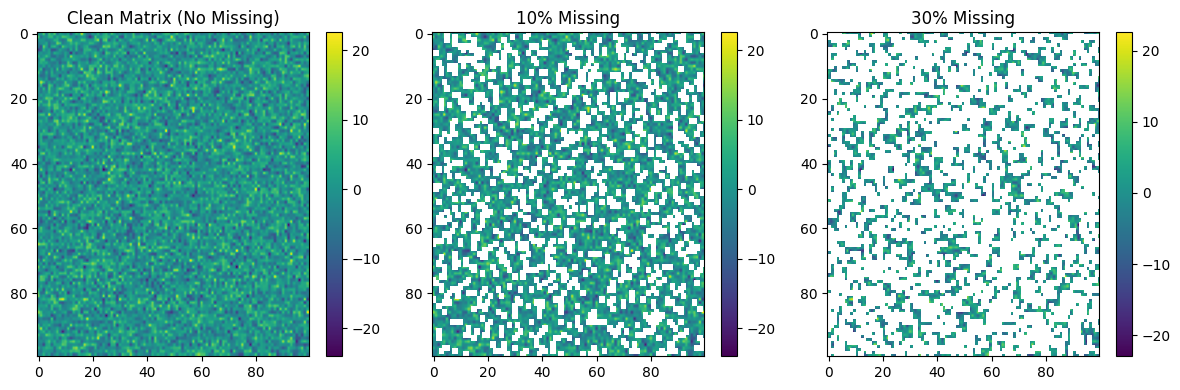

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure reproducibility
np.random.seed(42)

# Matrix dimensions: number of samples, latent dimension, feature dimension
n, d, m = 10000, 100, 1000

# Step 1: Construct the clean signal matrix A_clean = S D U
S = np.random.randn(n, d)                  # Random signal coefficient matrix (10000 x 100)
D = np.diag(np.linspace(10, 1, d))         # Diagonal matrix with values decreasing from 10 to 1
U, _ = np.linalg.qr(np.random.randn(d, m)) # Orthonormal basis matrix (100 x 1000)
A_clean = S @ D @ U                        # Clean matrix (10000 x 1000)

# Step 2: Add Gaussian noise
zeta = 1
N = np.random.randn(*A_clean.shape)        # Gaussian noise matrix (10000 x 1000)
A_noisy = A_clean + N / zeta               # Noisy matrix

# Step 3: Create missing value masks (10% and 30%)
mask_10 = np.random.rand(*A_noisy.shape) > 0.1  # Keep 90% of the values
mask_30 = np.random.rand(*A_noisy.shape) > 0.3  # Keep 70% of the values

A_10_missing = A_noisy * mask_10
A_30_missing = A_noisy * mask_30

# Step 4: Save data
os.makedirs("data", exist_ok=True)
np.savez("data/matrix_clean.npz", A=A_noisy, S=S, D=D, U=U, N=N)
np.save("data/matrix_10_missing.npy", A_10_missing)
np.save("data/matrix_30_missing.npy", A_30_missing)
np.save("data/mask_10.npy", mask_10)
np.save("data/mask_30.npy", mask_30)

# Step 5: Visualize top-left 100x100 region of the matrices
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Clean Matrix (No Missing)")
plt.imshow(A_noisy[:100, :100], aspect='auto', cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("10% Missing")
plt.imshow(np.where(mask_10[:100, :100], A_10_missing[:100, :100], np.nan), aspect='auto', cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("30% Missing")
plt.imshow(np.where(mask_30[:100, :100], A_30_missing[:100, :100], np.nan), aspect='auto', cmap='viridis')
plt.colorbar()

plt.tight_layout()
plt.show()


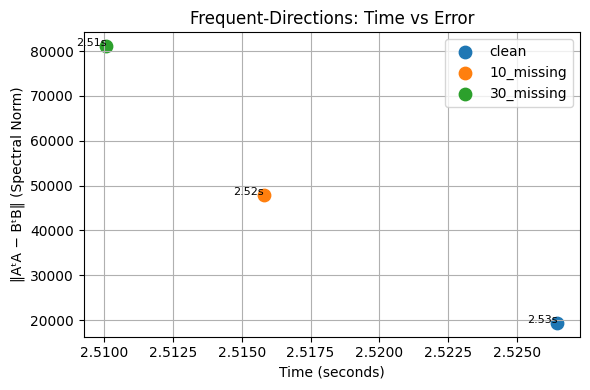

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os



# This is frequent_directions_buffered algo

# Load matrices
data = np.load("data/matrix_clean.npz")
A_clean = data["A"]
A_10 = np.load("data/matrix_10_missing.npy")
A_30 = np.load("data/matrix_30_missing.npy")

# Sketch size ℓ
l = 100

# For logging
errors = {}
timings = {}

def frequent_directions_buffered(A, l):
    """
    Stable version of Frequent-Directions using 2ℓ × d buffer.
    Reduces numerical instability and avoids per-row SVD.
    """
    n, d = A.shape
    B = np.zeros((2 * l, d))
    row_ptr = 0

    for i in range(n):
        B[row_ptr] = A[i]
        row_ptr += 1

        # Once buffer is full, compress it
        if row_ptr == 2 * l:
            _, s, Vt = np.linalg.svd(B, full_matrices=False)
            delta = s[l-1]**2  # Use the ℓ-th singular value (0-based index is l-1)
            s = np.maximum(0, np.sqrt(s**2 - delta))
            B[:l] = np.diag(s[:l]) @ Vt[:l]

            B[l:] = 0
            row_ptr = l

    return B[:l]  # final sketch

def evaluate_and_plot(name, A):
    start = time.time()
    B = frequent_directions_buffered(A, l)
    elapsed = time.time() - start

    # Spectral error: ‖AᵗA − BᵗB‖
    AtA = A.T @ A
    BtB = B.T @ B
    error_matrix = AtA - BtB
    spectral_error = np.linalg.norm(error_matrix, 2)

    # Save heatmap of partial error matrix
    os.makedirs("results", exist_ok=True)
    plt.figure(figsize=(5, 4))
    plt.title(f"Error Heatmap: {name}")
    plt.imshow(np.abs(error_matrix[:100, :100]), cmap="hot", aspect="auto")
    plt.colorbar(label="‖AᵗA − BᵗB‖ (partial)")
    plt.tight_layout()
    plt.savefig(f"results/fd_heatmap_{name}.png")
    plt.close()

    # Store metrics
    errors[name] = spectral_error
    timings[name] = elapsed

    return spectral_error, elapsed

# Run FD on all 3 versions
evaluate_and_plot("clean", A_clean)
evaluate_and_plot("10_missing", A_10)
evaluate_and_plot("30_missing", A_30)

# Plot time vs error
plt.figure(figsize=(6, 4))
for name in ["clean", "10_missing", "30_missing"]:
    plt.scatter(timings[name], errors[name], label=name, s=80)
    plt.text(timings[name], errors[name], f"{timings[name]:.2f}s", fontsize=8, ha='right')

plt.title("Frequent-Directions: Time vs Error")
plt.xlabel("Time (seconds)")
plt.ylabel("‖AᵗA − BᵗB‖ (Spectral Norm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/fd_time_vs_error.png")
plt.show()


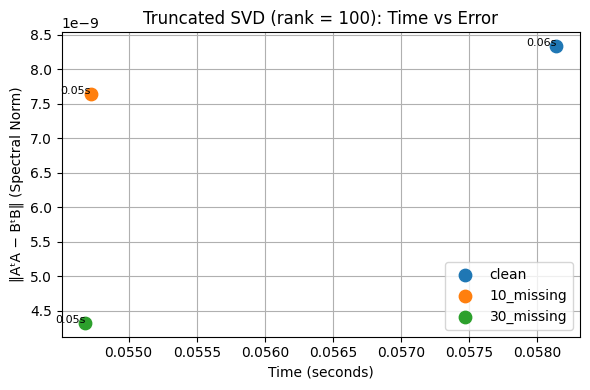

In [3]:
# Truncated SVD: Rank-100 approximation and comparison on clean, 10%, and 30% missing matrices

import numpy as np
import matplotlib.pyplot as plt
import time
import os



# Load matrices
data = np.load("data/matrix_clean.npz")
A_clean = data["A"]
A_10 = np.load("data/matrix_10_missing.npy")
A_30 = np.load("data/matrix_30_missing.npy")

# Truncated rank (controlled to match Frequent-Directions ℓ = 100)
k = 100

# Record results
errors = {}
timings = {}

def truncated_svd_reconstruct(A, k):
    """
    Perform rank-k truncated SVD:
    A ≈ U_k Σ_k V_kᵗ, where k is the target rank.
    This reduces the number of degrees of freedom to match sketch size.
    """
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    U_k = U[:, :k]
    S_k = np.diag(s[:k])
    Vt_k = Vt[:k, :]
    A_k = U_k @ S_k @ Vt_k
    return A_k

def evaluate_and_plot(name, A):
    start = time.time()
    A_k = truncated_svd_reconstruct(A, k)
    elapsed = time.time() - start

    # Spectral norm error: ‖AᵗA − BᵗB‖
    AtA = A.T @ A
    BtB = A_k.T @ A_k
    error_matrix = AtA - BtB
    spectral_error = np.linalg.norm(error_matrix, 2)

    # Save partial heatmap of the error matrix
    os.makedirs("results", exist_ok=True)
    plt.figure(figsize=(5, 4))
    plt.title(f"SVD Error Heatmap: {name}")
    plt.imshow(np.abs(error_matrix[:100, :100]), cmap="hot", aspect="auto")
    plt.colorbar(label="‖AᵗA − BᵗB‖ (partial)")
    plt.tight_layout()
    plt.savefig(f"results/svd_heatmap_{name}.png")
    plt.close()

    # Store error and time
    errors[name] = spectral_error
    timings[name] = elapsed

# Evaluate all three matrices
evaluate_and_plot("clean", A_clean)
evaluate_and_plot("10_missing", A_10)
evaluate_and_plot("30_missing", A_30)

# Plot Time vs Error
plt.figure(figsize=(6, 4))
for name in ["clean", "10_missing", "30_missing"]:
    plt.scatter(timings[name], errors[name], label=name, s=80)
    plt.text(timings[name], errors[name], f"{timings[name]:.2f}s", fontsize=8, ha='right')

plt.title("Truncated SVD (rank = 100): Time vs Error")
plt.xlabel("Time (seconds)")
plt.ylabel("‖AᵗA − BᵗB‖ (Spectral Norm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/svd_time_vs_error.png")
plt.show()


Using device: cuda


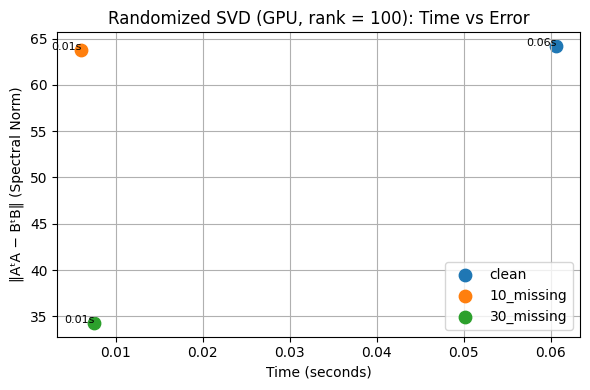

In [4]:
# Randomized SVD (GPU, no thread control) - Fair comparison with rank = 100

import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# Select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load data into PyTorch tensors on GPU
A_clean = torch.tensor(np.load("data/matrix_clean.npz")["A"], dtype=torch.float32, device=device)
A_10 = torch.tensor(np.load("data/matrix_10_missing.npy"), dtype=torch.float32, device=device)
A_30 = torch.tensor(np.load("data/matrix_30_missing.npy"), dtype=torch.float32, device=device)

# Parameters
k = 100            # Target rank (same as FD/SVD)
oversample = 20    # Oversampling to improve approximation

# Store results
errors = {}
timings = {}

def randomized_svd(A, k, oversample=20):
    """
    Perform Randomized SVD (on GPU using PyTorch).
    A ≈ Q * (SVD of QᵗA), where Q is a projection subspace.
    """
    n, d = A.shape
    P = torch.randn(d, k + oversample, device=A.device)
    Z = A @ P                             # Step 1: Project A into smaller space
    Q, _ = torch.linalg.qr(Z)            # Step 2: Orthonormal basis Q
    Y = Q.T @ A                           # Step 3: Compressed matrix
    Uy, S, Vt = torch.linalg.svd(Y, full_matrices=False)
    A_k = (Q @ Uy[:, :k]) @ torch.diag(S[:k]) @ Vt[:k]  # Final approximation
    return A_k

def evaluate_and_plot(name, A):
    torch.cuda.synchronize()
    start = time.time()
    A_k = randomized_svd(A, k, oversample=oversample)
    torch.cuda.synchronize()
    elapsed = time.time() - start

    # Error metric: ‖AᵗA − BᵗB‖ (spectral norm)
    AtA = A.T @ A
    BtB = A_k.T @ A_k
    error_matrix = AtA - BtB
    spectral_error = torch.linalg.norm(error_matrix, ord=2).item()

    # Heatmap (partial view, save to file)
    heatmap = error_matrix[:100, :100].abs().cpu().numpy()
    plt.figure(figsize=(5, 4))
    plt.title(f"RandSVD Error Heatmap: {name}")
    plt.imshow(heatmap, cmap="hot", aspect="auto")
    plt.colorbar(label="‖AᵗA − BᵗB‖ (partial)")
    plt.tight_layout()
    os.makedirs("results", exist_ok=True)
    plt.savefig(f"results/randsvd_heatmap_{name}.png")
    plt.close()

    errors[name] = spectral_error
    timings[name] = elapsed

# Run evaluation on all 3 matrices
evaluate_and_plot("clean", A_clean)
evaluate_and_plot("10_missing", A_10)
evaluate_and_plot("30_missing", A_30)

# Time vs Error plot
plt.figure(figsize=(6, 4))
for name in ["clean", "10_missing", "30_missing"]:
    plt.scatter(timings[name], errors[name], label=name, s=80)
    plt.text(timings[name], errors[name], f"{timings[name]:.2f}s", fontsize=8, ha='right')

plt.title("Randomized SVD (GPU, rank = 100): Time vs Error")
plt.xlabel("Time (seconds)")
plt.ylabel("‖AᵗA − BᵗB‖ (Spectral Norm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/randsvd_time_vs_error.png")
plt.show()


Using device: cuda


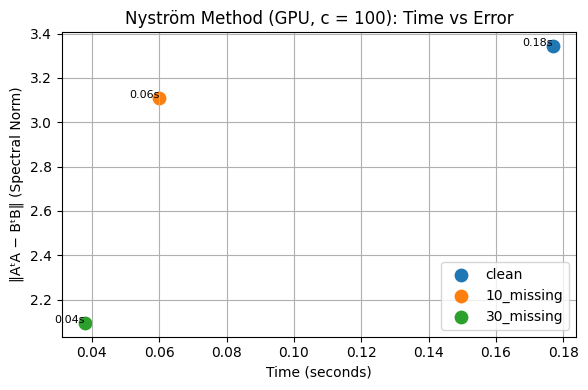

In [5]:
# Nyström Method (GPU, rank = 100): Fair comparison with other sketching methods

import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load matrices onto GPU
A_clean = torch.tensor(np.load("data/matrix_clean.npz")["A"], dtype=torch.float32, device=device)
A_10 = torch.tensor(np.load("data/matrix_10_missing.npy"), dtype=torch.float32, device=device)
A_30 = torch.tensor(np.load("data/matrix_30_missing.npy"), dtype=torch.float32, device=device)

# Sampling columns
c = 100  # number of columns to sample

# Results
errors = {}
timings = {}

def nystrom_gpu(A, c):
    """
    Nyström approximation on GPU using PyTorch.
    A ≈ C W⁺ Cᵗ A, where C is sampled columns, W = CᵗC.
    """
    n, d = A.shape
    idx = torch.randperm(d, device=A.device)[:c]
    C = A[:, idx]                    # C: sampled columns
    W = C.T @ C                      # W: inner submatrix
    try:
        W_inv = torch.linalg.pinv(W)  # Moore-Penrose inverse
    except RuntimeError:
        W_inv = torch.linalg.pinv(W + 1e-4 * torch.eye(c, device=A.device))  # fallback
    A_k = C @ W_inv @ C.T @ A        # Full projection
    return A_k

def evaluate_and_plot(name, A):
    torch.cuda.synchronize()
    start = time.time()
    A_k = nystrom_gpu(A, c)
    torch.cuda.synchronize()
    elapsed = time.time() - start

    AtA = A.T @ A
    BtB = A_k.T @ A_k
    error_matrix = AtA - BtB
    spectral_error = torch.linalg.norm(error_matrix, ord=2).item()

    # Save heatmap
    heatmap = error_matrix[:100, :100].abs().cpu().numpy()
    plt.figure(figsize=(5, 4))
    plt.title(f"Nyström Error Heatmap: {name}")
    plt.imshow(heatmap, cmap="hot", aspect="auto")
    plt.colorbar(label="‖AᵗA − BᵗB‖ (partial)")
    plt.tight_layout()
    os.makedirs("results", exist_ok=True)
    plt.savefig(f"results/nystrom_heatmap_{name}.png")
    plt.close()

    errors[name] = spectral_error
    timings[name] = elapsed

# Evaluate
evaluate_and_plot("clean", A_clean)
evaluate_and_plot("10_missing", A_10)
evaluate_and_plot("30_missing", A_30)

# Plot time vs error
plt.figure(figsize=(6, 4))
for name in ["clean", "10_missing", "30_missing"]:
    plt.scatter(timings[name], errors[name], label=name, s=80)
    plt.text(timings[name], errors[name], f"{timings[name]:.2f}s", fontsize=8, ha='right')

plt.title("Nyström Method (GPU, c = 100): Time vs Error")
plt.xlabel("Time (seconds)")
plt.ylabel("‖AᵗA − BᵗB‖ (Spectral Norm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/nystrom_time_vs_error.png")
plt.show()


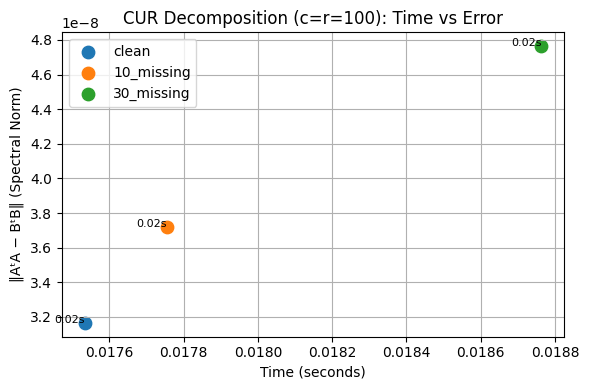

In [6]:
# CUR Decomposition (CPU-based) for matrix approximation

import numpy as np
import matplotlib.pyplot as plt
import time
import os

# Load matrices
A_clean = np.load("data/matrix_clean.npz")["A"]
A_10 = np.load("data/matrix_10_missing.npy")
A_30 = np.load("data/matrix_30_missing.npy")

# Compression parameters
c = r = 100  # number of columns/rows to sample

# Record results
errors = {}
timings = {}

def cur_decomposition(A, c, r):
    """
    CUR decomposition: A ≈ C U R
    - C: sampled columns of A
    - R: sampled rows of A
    - U: intersection (W) and its pseudoinverse
    """
    n, d = A.shape

    col_idx = np.random.choice(d, size=c, replace=False)
    row_idx = np.random.choice(n, size=r, replace=False)

    C = A[:, col_idx]       # shape: n x c
    R = A[row_idx, :]       # shape: r x d
    W = A[np.ix_(row_idx, col_idx)]  # shape: r x c

    try:
        W_pinv = np.linalg.pinv(W)
    except np.linalg.LinAlgError:
        W_pinv = np.linalg.pinv(W + 1e-6 * np.eye(W.shape[0]))

    A_approx = C @ W_pinv @ R
    return A_approx

def evaluate_and_plot(name, A):
    start = time.time()
    A_k = cur_decomposition(A, c, r)
    elapsed = time.time() - start

    AtA = A.T @ A
    BtB = A_k.T @ A_k
    error_matrix = AtA - BtB
    spectral_error = np.linalg.norm(error_matrix, 2)

    # Heatmap of partial error
    plt.figure(figsize=(5, 4))
    plt.title(f"CUR Error Heatmap: {name}")
    plt.imshow(np.abs(error_matrix[:100, :100]), cmap="hot", aspect="auto")
    plt.colorbar(label="‖AᵗA − BᵗB‖ (partial)")
    plt.tight_layout()
    os.makedirs("results", exist_ok=True)
    plt.savefig(f"results/cur_heatmap_{name}.png")
    plt.close()

    errors[name] = spectral_error
    timings[name] = elapsed

# Evaluate all matrices
evaluate_and_plot("clean", A_clean)
evaluate_and_plot("10_missing", A_10)
evaluate_and_plot("30_missing", A_30)

# Plot Time vs Error
plt.figure(figsize=(6, 4))
for name in ["clean", "10_missing", "30_missing"]:
    plt.scatter(timings[name], errors[name], label=name, s=80)
    plt.text(timings[name], errors[name], f"{timings[name]:.2f}s", fontsize=8, ha='right')

plt.title("CUR Decomposition (c=r=100): Time vs Error")
plt.xlabel("Time (seconds)")
plt.ylabel("‖AᵗA − BᵗB‖ (Spectral Norm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/cur_time_vs_error.png")
plt.show()
